In [4]:
from ToxicTextsDataset import ToxicTextsDataset 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.multiclass import OneVsRestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

import torch
import torch.nn as nn

### Batches

In [43]:
batch_size = 5
use_cuda = False
validation_size = 0.1
voc_size = 5000
    
dataset = ToxicTextsDataset(n_test_batches=1000, 
                            n_train_batches=500, 
                            n_valid_batches=16,
                            valid_size=validation_size,
                            test_size=0.,
                            batch_size=batch_size, 
                            vocab_size=voc_size, 
                            verbose=1,
                            use_cuda = use_cuda)

Generating vocabulary... Completed
Creating train dataset... Completed
Creating validation dataset... Completed


In [170]:
# create test
for i, sample in enumerate(dataset.test_dataset):
    embed = embedding(sample['input']).data.numpy()
    cl = sample['cl_features'].data.numpy()
    
    if i == 0:
        X_test = np.concatenate((embed, cl), axis = 1)
        y_test = sample['labels'].data.numpy()[:,class_num]
    else:
        X_test = np.concatenate((X_test, np.concatenate((embed, cl), axis = 1)), axis = 0)
        y_test = np.concatenate((y_test,sample['labels'].data.numpy()[:,class_num]), axis = 0)
   

In [48]:

# фит модели для одного класса
embedding = nn.EmbeddingBag(5000, embedding_dim=10000)
class_num = 1 # which class to choose
clf = SGDClassifier(loss = 'log', warm_start=True, tol = 1e-5)
# clf = PassiveAggressiveClassifier()

# dataset.mode = 'train'
dataset.shuffle()
all_predictions = []
all_true_labels = []
scores = []
for sample in dataset.train_dataset:    
    embed = embedding(sample['input']).data.numpy() # из вектора получаем спарс матрицу
    cl = sample['cl_features'].data.numpy() # берем фичи
    
    X_train = np.concatenate((embed, cl), axis = 1) # тотал трейн
    y_train = sample['labels'].data.numpy()[:,class_num]
    
    #clf.fit(X_train, y_train) 
    clf.partial_fit(X_train, y_train, classes=np.array([0, 1])) 
    scores.append(clf.score(X_test, y_test))

# for sample in dataset.valid_dataset:
#     embed = embedding(sample['input']).data.numpy()
#     cl = sample['cl_features'].data.numpy()

#     X_test = np.concatenate((embed, cl), axis = 1)
#     y_test = sample['labels'].data.numpy()[:,class_num]
#     break
#     pred_proba = clf.predict_proba(X_test)
#     pred = clf.predict(X_test)
#     all_predictions =  np.concatenate((all_predictions, pred))
#     all_true_labels = np.concatenate((y_test,all_true_labels))
# print(f1_score(all_predictions, all_true_labels))

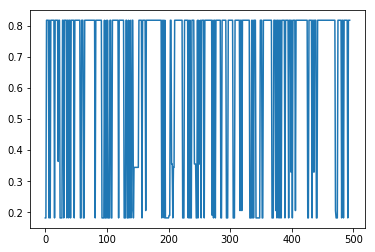

In [54]:
fig, ax = plt.subplots()
ax.plot(scores)

In [52]:
len(scores)

495

In [46]:
y_test.shape[0] - np.sum(y_test)

1100

In [ ]:
### Chain == 6 binary classifiers

embedding = nn.EmbeddingBag(5000, embedding_dim=1000)
base_clf = [SGDClassifier(loss = 'log', warm_start = True) for i in range(6)]

y_ordered = np.arange(6)
np.random.seed(10)
np.random.shuffle(y_ordered)
dataset.shuffle()
all_predictions = [[] for i in range(6)]
all_true_labels = [[] for i in range(6)]
for i, label in enumerate(y_ordered):
    for sample in dataset.train_dataset:    
        embed = embedding(sample['input']).data.numpy()
        cl = sample['cl_features'].data.numpy()
    
        X_train = np.concatenate((embed, cl), axis = 1)
        y_train = sample['labels'].data.numpy()[:,label]
        for p in range(i):
            pred = base_clf[y_ordered[p]].predict_proba(X_train)[:,1]
            X_train = np.concatenate((X_train, np.atleast_2d(pred).T), axis = 1)
        base_clf[label].partial_fit(X_train, y_train, classes=np.array([0, 1]))

    for sample in dataset.valid_dataset:
        embed = embedding(sample['input']).data.numpy()
        cl = sample['cl_features'].data.numpy()

        X_test = np.concatenate((embed, cl), axis = 1)
        y_test = sample['labels'].data.numpy()[:,label]
        for p in range(i):
            pred = base_clf[y_ordered[p]].predict_proba(X_test)[:,1]
            X_test = np.concatenate((X_test, np.atleast_2d(pred).T), axis = 1)
    
        pred = base_clf[label].predict(X_test)
        all_predictions[label] =  np.concatenate((all_predictions[label], pred))
        all_true_labels[label] = np.concatenate((y_test,all_true_labels[label]))  
        
       # previous_params = base_clf[label].get_params() 
    print(f1_score(all_predictions[label], all_true_labels[label], average='weighted'))

In [182]:
print(f1_score(np.asarray(all_predictions), np.asarray(all_true_labels) ,average='weighted'))


0.479955348018


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(6, 15400)

In [139]:
f1_score(all_predictions, all_true_labels)
#sum(all_true_labels)
#all_predictions.shape
i = 0
a = 100
for i in range(i):
    print(i)
    a = 0
print(a)

100


### Simple way

In [87]:
df = pd.read_csv('train.csv')

vectorizer = TfidfVectorizer(max_features=voc_size, analyzer='word', max_df = .95, min_df=.01)
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1], df.iloc[:,2:], test_size=validation_size)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

array([1, 1, 1, 1, 1, 1, 1])

1. Choose best params for a chain

In [22]:
clf = [LogisticRegression()
est = ClassifierChain(clf, order='random', random_state=1)

param_grid = {'base_estimator__penalty':['l1','l2'], 'base_estimator__C':[1e-1**i for i in [-2, 1, 2, 4]]}
grid = GridSearchCV(est, cv=10, n_jobs=-1, param_grid=param_grid)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=ClassifierChain(base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
        cv=None, order='random', random_state=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'base_estimator__penalty': ['l1', 'l2'], 'base_estimator__C': [99.99999999999999, 0.1, 0.010000000000000002, 0.00010000000000000002]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [23]:
grid.best_estimator_

ClassifierChain(base_estimator=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
        cv=None, order='random', random_state=1)

In [ ]:
def learn_chains(clf, num_chains, X_train, X_test, y_train, y_test):
    
    # Train 'num_chain' chains
    # Each chain consists of 6 binary classiers
    chains = [ClassifierChain(clf, order='random', random_state=i) for i in range(num_chains)]
    for k, chain in enumerate(chains):
        print('fitting chain {}...'.format(k+1))
        chain.fit(X_train, y_train)
    print('Chains fitted!')
    
    y_pred_chains = np.array([chain.predict(X_test) for chain in chains])
    chain_scores = [f1_score(y_test, y >= .5, average='weighted') for y in y_pred_chains]
    
    # Ensemble of chains
    y_pred_ensemble = y_pred_chains.mean(axis=0)
    ensemble_score = f1_score(y_test,  y_pred_ensemble >= .5, average='weighted')    
    return model_scores


fitting chain 0...
fitting chain 1...
fitting chain 2...
fitting chain 3...
fitting chain 4...
fitting chain 5...
fitting chain 6...
fitting chain 7...
fitting chain 8...
fitting chain 9...
Done!


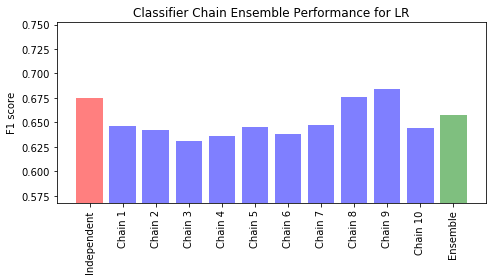

In [ ]:


clfs = [LogisticRegression(), KNeighborsClassifier()]

clf_name = ['LR', 'kNN']
num_chains = 10
ovr_score = []
chain_scores = [[] for i in range(len(clfs))]
ensemble_score = []

for j, clf in enumerate(clfs):
    # Independent
    ovr = OneVsRestClassifier(clf)
    ovr.fit(X_train, y_train)
    y_pred_ovr = ovr.predict(X_test)
    ovr_score.append(f1_score(y_test, y_pred_ovr, average='weighted'))

    # Chains
    chains = [ClassifierChain(clf, order='random', random_state=i) for i in range(num_chains)]

    for k, chain in enumerate(chains):
        print('fitting chain {}...'.format(k))
        chain.fit(X_train, y_train)
    print('Done!')
    
    y_pred_chains = np.array([chain.predict(X_test) for chain in chains])
    chain_scores[j] = [f1_score(y_test, y_pred_chain >= .5, average='weighted')
                         for y_pred_chain in y_pred_chains]

    y_pred_ensemble = y_pred_chains.mean(axis=0)
    ensemble_score.append(f1_score(y_test,  y_pred_ensemble >= .5, average='weighted'))

    model_scores = [ovr_score[j]] + chain_scores[j] + [ensemble_score[j]]
    

    model_names = ['Independent'] + ['Chain {}'.format(c+1) for c in range(num_chains)] + ['Ensemble']

    x_pos = np.arange(len(model_names))

# # Plot the Jaccard similarity scores for the independent model, each of the
# # chains, and the ensemble (note that the vertical axis on this plot does
# # not begin at 0).

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.set_title('Classifier Chain Ensemble Performance for {}'.format(clf_name[j]))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(model_names, rotation='vertical')
    ax.set_ylabel('F1 score')
    ax.set_ylim([min(model_scores) * .9, max(model_scores) * 1.1])
    colors = ['r'] + ['b'] * len(chain_scores[j]) + ['g']
    ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
    plt.tight_layout()
    plt.show()

In [ ]:
# Chains
chain = ClassifierChain(KNeighborsClassifier(), order='random', random_state = 1)
chain.fit(X_train, y_train)
chain.predict(X_test)
